In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
from pandas.tseries.offsets import BDay
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
files = os.listdir("E:\\Research-Stuff\\Processed\\")

In [3]:
data = pd.DataFrame()
for _file in files:
    df = pd.read_csv(os.path.join("E:\\Research-Stuff\\Processed\\",_file))
#     df['Series'] = _file.replace('.csv','')
    df = df.filter(['Date','Close']).rename(columns={'Close':_file.replace(".csv","")}).drop_duplicates().set_index('Date')
    data = pd.concat([data,df],axis=1)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [54]:
dailyReturns = data.pct_change()

In [55]:
dailyReturns.index = pd.to_datetime(dailyReturns.index)

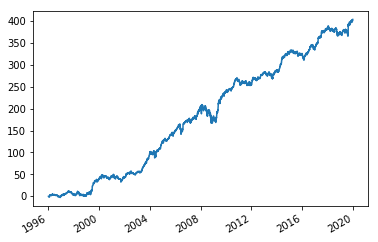

In [7]:
## mat lab kuch bhi
(dailyReturns.sum(axis=1)).cumsum().plot()

In [8]:
sec_count =  dailyReturns.shape[1] # securities count

In [9]:
initial_weight = 1.0/sec_count

In [10]:
# dailyReturns = dailyReturns.fillna(0) ## filling all nans with 0 ## <<<<please think more about this too
# dailywts = dailyReturns.copy() # creating a copy

In [44]:
for col in dailywts.columns:
    dailywts[col].values[:] = 1 #np.random.random(size=(1,5970)) ## reandom dailywts

In [45]:
def assetReturn(dailywts,assets='ALL'):
    '''
    Function to get the daily return series for a list of equiyt IDs
    @params: daily , a pandas df with the index dates same as the index date for the dailyReturns series
    @assets: list of all asset ids which can be passes or pass ALL to get a df for each compoenent return
    '''
    ## re-check if we dailywts is needed to be assigned as global
    if assets =='ALL':
        return dailyReturns.multiply(dailywts)
    return dailyReturns.multiply(dailywts)[assets]
def portReturn(dailywts):
    '''
    Function return the daily portfolio return 
    '''
    return pd.DataFrame(assetReturn(dailywts,assets='ALL').sum(axis=1),columns=['PortfolioReturn'])
def portReturnSeries(dailywts):
    '''
    Function return the cumulative portfolio return i.e. running portfolio return
    '''
    cum_port_retun_series = (portReturn(dailywts)+1).cumprod()
    return cum_port_retun_series.add_suffix('Series')
def assetReturnSeries(dailywts,assets='ALL'):
    '''
    Function to get the cumulative return series for a list of equiyt IDs
    @params: daily , a pandas df with the index dates same as the index date for the dailyReturns series
    @assets: list of all asset ids which can be passes or pass ALL to get a df for each compoenent return
    '''
    ## re-check if we dailywts is needed to be assigned as global
    return (assetReturn(dailywts,assets)+1).cumprod().add_suffix('Series')
def assetTurnover(dailywts,assets='ALL'):
    '''
    Function to get the daily turnover series for a list of equiyt IDs
    @params: daily , a pandas df with the index dates same as the index date for the dailyReturns series
    @assets: list of all asset ids which can be passes or pass ALL to get a df for each compoenent return
    # turnover is based on formulae (today wts - yesterday's wts)*100/2
    '''
    turnover = np.abs((dailywts-dailywts.shift(1))/2).fillna(1)*100
    if assets=='ALL':
        return turnover
    return turnover[assets]
def portTurnover(dailywts):
    '''
    Function return the daily portfolio turnover 
    '''
    return pd.DataFrame(assetTurnover(dailywts,assets='ALL').sum(axis=1),columns=['PortfolioTurnover'])/dailywts.shape[1]
def drawdown(portfolioDailyReturn):
    '''
    Returns portfolio drawdown in percentage
    @params: portfolioDailyReturn series
    '''
    ## further make it generic to return dates , plot and top 5 drawdowns
    returns = (portfolioDailyReturn+1).cumprod() # converts daily returns into a cumulative return series
    xs = np.log(returns).values
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    drawdown = (returns.iloc[i]/returns.iloc[j]-1)*100
    return drawdown.values[0]
#     returns.plot(figsize=(14,8))
#     plt.plot([returns.index[i], returns.index[j]], [returns.iloc[i], returns.iloc[j]], 'o', color='Red', markersize=10)
    

In [46]:
# returns = portReturn(dailywts)
# drawdown(returns)

In [30]:
## sharpe for the equities and also for the portfolio
def sharpe(portfolioDailyReturn,rfr=.05):
    '''
    The function calculates and returns the portfolio sharpe
    @params: rfr = RiskFreRate in decimals
    Output: Based on (Rm-rfr)/std(portfolioReturn)
    '''
    return ((portfolioDailyReturn.mean()-.05)/portfolioDailyReturn.std()).values[0]


In [ ]:
def signal(data):
    r
    pass
    

In [47]:
portfolio = assetReturnSeries(dailywts).loc['2000-1-1':]

In [19]:
## rollign means for returns and volume

In [20]:
## inclusion of transaction cost , leverage ? 

In [77]:
%%timeit
rr = (dailyReturns+1).rolling(5,min_periods=3).apply(np.prod)

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:257: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


1 loop, best of 3: 875 ms per loop


In [127]:
def quintiles(rd,bins=4):
    '''
    The function takes in the value series ( returns, volume , cap , etc)
    and returns the cross sectional rank for each date
    '''
    ## Any frequency chocie as param
    ranks = rd.rank(axis=1) ## lowest rank means the lowest value
    for col in ranks.columns:
        ranks[col] = pd.cut(ranks[col],bins,labels=False)
    return ranks

In [165]:
quint = quintiles(rr)

In [166]:
q3 = quint.replace([np.nan,1,2,0],0).replace([3],1)

In [167]:
wts = q3.div(q3.sum(axis=1),axis='rows')

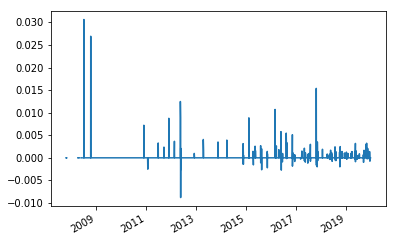

In [176]:
assetReturn(wts)['SBIN'].plot()

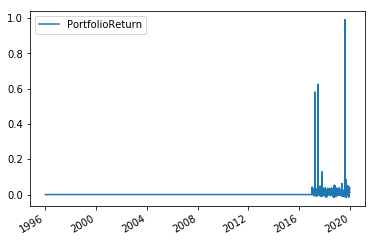

In [196]:
portReturn(wts).plot()

In [201]:
t= portReturn(wts)[portReturn(wts)['PortfolioReturn']!=0]

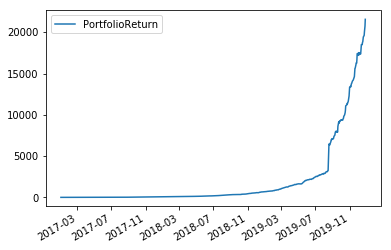

In [205]:
(t+1).cumprod().plot()

In [206]:
import os
os.getcwd()

'C:\\Users\\spundir'